#### Troubleshooting the tokenizer in polyjuice

In [12]:
from transformers import AutoTokenizer, AutoModelForCausalLM

model_name = "uw-hai/polyjuice"
foundational_model=AutoModelForCausalLM.from_pretrained(model_name)
tokenizer=AutoTokenizer.from_pretrained(model_name)


input_prompt = "Her decision is rational. <|perturb|> [negation] Her decision is [BLANK]"

# Tokenize the input_prompt
tokens = tokenizer(input_prompt)
token_ids = tokens["input_ids"]

tokens_descomp = tokenizer.convert_ids_to_tokens(token_ids)

decoded_text = tokenizer.decode(token_ids)

# Extract tokens and their corresponding IDs
#tokens = inputs.tokens()
#token_ids = inputs.input_ids.squeeze().tolist()

print(tokens)
#print(token_ids)
print(decoded_text)
print(tokens_descomp)
#print(len(token_ids ))
#print(tokenizer.vocab_size)



{'input_ids': [9360, 2551, 318, 9377, 13, 1279, 91, 11766, 5945, 91, 29, 685, 12480, 341, 60, 2332, 2551, 318, 685, 9148, 15154, 60], 'attention_mask': [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]}
Her decision is rational. <|perturb|> [negation] Her decision is [BLANK]
['Her', 'Ġdecision', 'Ġis', 'Ġrational', '.', 'Ġ<', '|', 'pert', 'urb', '|', '>', 'Ġ[', 'neg', 'ation', ']', 'ĠHer', 'Ġdecision', 'Ġis', 'Ġ[', 'BL', 'ANK', ']']


# Soft prompting

### Data preprocessing

In [248]:
from ..PEFT.create_blanks import get_random_idxes, create_blanked_sents
from typing import List, Dict, Tuple
from spacy.tokens import Doc

def get_random_blanked_sentences(
    sentence: Tuple[str, Doc], 
    pre_selected_idxes: List[int]=None,
    deps: List[str]=None,
    is_token_only: bool=False,
    max_blank_sent_count: int=3,
    max_blank_block: int=1) -> List[str]:
    """Generate some random blanks for a given sentence

    Args:
        sentence (Tuple[str, Doc]): The sentence to be blanked,
            either in str or SpaCy doc.
        pre_selected_idxes (List[int], optional): 
            If set, only allow blanking a preset range of token indexes. 
            Defaults to None.
        deps (List[str], optional): 
            If set, only select from a subset of dep tags. Defaults to None.
        is_token_only (bool, optional):
            blank sub-spans or just single tokens. Defaults to False.
        max_blank_sent_count (int, optional): 
            maximum number of different blanked sentences. Defaults to 3.
        max_blank_block (int, optional): 
            maximum number of blanks per returned sentence. Defaults to 1.

    Returns:
        List[str]: blanked sentences
    """
    indexes = get_random_idxes(
        sentence, 
        pre_selected_idxes=pre_selected_idxes,
        deps=deps,
        is_token_only=is_token_only,
        max_count=max_blank_sent_count,
        max_blank_block=max_blank_block
    )
    blanked_sents = create_blanked_sents(sentence, indexes)
    return blanked_sents

ImportError: attempted relative import with no known parent package

In [228]:
import torch
from transformers import AutoTokenizer, AutoModelForCausalLM
import pandas as pd
from datasets import Dataset
from enum import Enum

class TargetType(Enum):
  PAD = 0
  CONTEXT = 1
  CONTEXT_SPECIAL = 2
  CONTEXT_INFILL_SEP = 3
  INFILL = 4
  INFILL_SPECIAL = 5
  #INFILL_REDUNDANT = 6

class TextGenerationSetup:

    """
    Class used to setup the prompts format for training
    """
    
    PERETURB_TOK = "<|perturb|>"
    BLANK_TOK = "[BLANK]"
    SEP_TOK = "[SEP]"
    ANSWER_TOK = "[ANSWER]"

    def __init__(self, model_path):
        self.device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
        self.tokenizer = AutoTokenizer.from_pretrained(model_path)
        self.tokenizer.pad_token = None #self.tokenizer.eos_token
        self.model = AutoModelForCausalLM.from_pretrained(model_path).to(self.device)

        # Add a new pad token if it doesn't exist and set it to ID 0
        if self.tokenizer.pad_token is None:
            self.tokenizer.add_special_tokens({'pad_token': '[PAD]'})
            self.tokenizer.pad_token_id = TargetType.PAD.value


    def get_prompts(self,doc, blanked_sents, is_complete_blank=True):
        prompts = []
        for bt in blanked_sents:
            tag = 'negation'
            sep_tok = TextGenerationSetup.SEP_TOK if bt and is_complete_blank else ""
            new_prompt = f"{doc.strip()} {TextGenerationSetup.PERETURB_TOK} [{tag}] {bt.strip()}".strip()
            #prompts.append(new_prompt)
            prompts.append(new_prompt.rstrip('.').strip())
        return prompts

    def get_answer_2(self,answer):
        prompts = []
        prompts.append(f"{TextGenerationSetup.SEP_TOK} {answer.strip()} {TextGenerationSetup.ANSWER_TOK}")
        #prompts.append(answer.strip())
        return prompts
    
    def get_answer(self,answers):
        sentence = ""
        initial = TextGenerationSetup.SEP_TOK
        for answer in answers:
            sentence += f"{initial} {answer.strip()} {TextGenerationSetup.ANSWER_TOK}"
            initial = ""
        return sentence
    
    
    def tokenize_function(self, examples):

        input_encodings = self.tokenizer(examples['input_text'], truncation=True, padding="max_length", max_length=100)
        return input_encodings
    
    
    
def process_dataframe(affixal_path, text_format ):

    """
    Processes a DataFrame containing text data to generate a dataset suitable for text generation tasks.

    This function reads a DataFrame from a pickle file, processes each row to replace specific cues with 
    a blank token, generates prompts and answers in the required format, and converts the processed data 
    into a format suitable for training a Hugging Face model.

    Args:
        affixal_path (str): Path to the pickle file containing the DataFrame with text data.
        text_format (TextGenerationSetup): An instance of the TextGenerationSetup class used for formatting prompts and answers.

    Returns:
        Dataset: A Hugging Face Dataset object containing the processed input and target texts.
    """

    train_data = []
    sentence_mask = True

    # Load the DataFrame from the pickle file
    filtered_df = pd.read_pickle(affixal_path)

    for _, row in filtered_df.iterrows():
        text = row['text']
        text_pos = row['text_substituted']
        cue = row['cues'].split()[0]  # Assuming 'cues' column contains space-separated cues

        if sentence_mask:
            # Replace the cue in the text with '[BLANK]'
            text_with_blank = text.replace(cue, '[BLANK]')
            
            # Generate the prompt and answer
            prompt_examples = text_format.get_prompts(text_pos, [text_with_blank]) # format the input prompts
            answer_formatted = text_format.get_answer([cue]) # format the answer

        else:
            text_with_blank = '[BLANK]'
            
            # Generate the prompt and answer
            prompt_examples = text_format.get_prompts(text_pos, [text_with_blank]) # format the input prompts
            answer_formatted = text_format.get_answer([text]) # format the answe

        # Combine the prompt and answer in the required format
        combined_sentence = f"{prompt_examples[0]} {answer_formatted}"
        train_data.append(combined_sentence)

    # Convert to a suitable format for Hugging Face Dataset
    train_dataset= pd.DataFrame(train_data, columns=["input_text"]) #columns=["input_text", "target_text"]
    train_dataset = Dataset.from_pandas(train_dataset)
    
    return train_dataset

# Setup the model
model_path = "uw-hai/polyjuice"  
text_format = TextGenerationSetup(model_path)

# Load affixal negations dataset in the right format for training
affixal_df = '../data/affixal/filtered_df.pkl' # Specify the path to the pickle file
train_dataset = process_dataframe(affixal_df,text_format)
tokenized_datasets = train_dataset.map(text_format.tokenize_function) # batched=True, remove_columns=["input_text", "target_text"])


c:\Users\daria\anaconda3\envs\negation\lib\site-packages\huggingface_hub\file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
c:\Users\daria\anaconda3\envs\negation\lib\site-packages\dill\_dill.py:412: PicklingWarning: Cannot locate reference to <enum 'TargetType'>.
  StockPickler.save(self, obj, save_persistent_id)
c:\Users\daria\anaconda3\envs\negation\lib\site-packages\dill\_dill.py:412: PicklingWarning: Cannot pickle <enum 'TargetType'>: __main__.TargetType has recursive self-references that trigger a RecursionError.
  StockPickler.save(self, obj, save_persistent_id)
Map: 100%|██████████| 59/59 [00:00<00:00, 1966.39 examples/s]


In [209]:
tokenized_datasets['input_text'][1]

'too much of it feels focused and underdeveloped . <|perturb|> [negation] [BLANK] [SEP] too much of it feels unfocused and underdeveloped . [ANSWER]'

In [234]:
train_dataset['input_text'][50]
train_dataset

Dataset({
    features: ['input_text'],
    num_rows: 59
})

### Integrating other datasets


In [138]:
data_path = '../data/non_verbal/sentence_negated_modified.txt' 

# Load the data into a DataFrame
df_dataset = pd.read_csv(data_path, delimiter='\t')

df_dataset.head()
    



,negated,original
0,Not all people have had the opportunities you have had.,Every person has had the opportunities you have had.
1,Not all people have had the opportunities you have had.,All people have had the opportunities you have had.
2,No one has had the opportunities you have had.,All people have had the opportunities you have had.
3,I saw nothing at all.,I saw something.
4,Not often do we see her lose her cool like that.,We frequently see her lose her cool like that.


In [109]:
first_row = df_dataset.loc[0]
print(first_row['negated'])
print(first_row)

negated = first_row['negated']
original = first_row['original']

####### Function



Not all people have had the opportunities you have had.
negated     Not all people have had the opportunities you have had.
original       Every person has had the opportunities you have had.
Name: 0, dtype: object


In [146]:
import numpy as np
import pandas as pd
from difflib import SequenceMatcher

# Create DataFrame
df = df_dataset

def mask_differences(negated, original):

    # Tokenize sentences
    negated_tokens = np.array(negated.split())
    original_tokens = np.array(original.split())
    
    # Use SequenceMatcher to find matching blocks
    matcher = SequenceMatcher(None, negated_tokens, original_tokens)
    
    # Initialize mask tokens and list to capture masked segments
    mask_tokens = []
    masked_info = []
    prev_end = 0
    
    for tag, i1, i2, j1, j2 in matcher.get_opcodes():
        if tag == 'replace' or tag == 'delete':
            if prev_end < i1:
                # Add [BLANK] for non-matching segments
                mask_tokens.extend(['[BLANK]'] * (i1 - prev_end))
                # Capture the masked segment
                masked_info.append(' '.join(negated_tokens[prev_end:i1]))
            else:
                # Consolidate contiguous [BLANK] tokens
                if mask_tokens and mask_tokens[-1] == '[BLANK]':
                    mask_tokens = mask_tokens[:-1]
                mask_tokens.append('[BLANK]')
                masked_info.append(' '.join(negated_tokens[i1:i2]))
        elif tag == 'insert':
            # Skip inserted parts as they are not in negated_tokens
            pass
        else:  # 'equal'
            # Add matching tokens to the mask
            mask_tokens.extend(negated_tokens[i1:i2])
        
        prev_end = i2
    
    # Handle trailing [BLANK] segments
    if prev_end < len(negated_tokens):
        mask_tokens.extend(['[BLANK]'] * (len(negated_tokens) - prev_end))
        masked_info.append(' '.join(negated_tokens[prev_end:]))
    
    # Consolidate contiguous [BLANK] segments into a single [BLANK]
    mask_array = []
    in_blank_segment = False
    for token in mask_tokens:
        if token == '[BLANK]':
            if not in_blank_segment:
                mask_array.append('[BLANK]')
                in_blank_segment = True
        else:
            mask_array.append(token)
            in_blank_segment = False
    
    # Convert mask tokens to a single string
    masked_sentence = ' '.join(mask_array)
    
    return masked_sentence, masked_info

# Apply function to the DataFrame
df[['mask', 'masked_info']] = df.apply(lambda row: pd.Series(mask_differences(row['negated'], row['original'])), axis=1)

# Convert 'masked_info' column to lists of masked segments
df['masked_info'] = df['masked_info'].apply(lambda x: [seg for seg in x if seg.strip()])

# Display the DataFrame
df.head()


,negated,original,mask,masked_info
0,Not all people have had the opportunities you have had.,Every person has had the opportunities you have had.,[BLANK] had the opportunities you have had.,[Not all people have]
1,Not all people have had the opportunities you have had.,All people have had the opportunities you have had.,[BLANK] people have had the opportunities you have had.,[Not all]
2,No one has had the opportunities you have had.,All people have had the opportunities you have had.,[BLANK] had the opportunities you have had.,[No one has]
3,I saw nothing at all.,I saw something.,I saw [BLANK],[nothing at all.]
4,Not often do we see her lose her cool like that.,We frequently see her lose her cool like that.,[BLANK] see her lose her cool like that.,[Not often do we]


In [167]:
SEP_TOK = "[SEP]"
ANSWER_TOK = "[ANSWER]"

def get_answer(answers):
    sentence = ""
    initial = SEP_TOK
    for answer in answers:
        sentence += f"{initial} {answer.strip()} {ANSWER_TOK}"
        initial = ""
    return sentence

exp = df['masked_info'][45]

xx = get_answer(exp)
print(xx)

[SEP] Not unreasonably, [ANSWER] asked [ANSWER]


In [221]:
from datasets import load_dataset, concatenate_datasets

SEP_TOK = "[SEP]"
ANSWER_TOK = "[ANSWER]"

def get_answer2(answers):
    sentence = ""
    initial = SEP_TOK
    for answer in answers:
        sentence += f"{initial} {answer.strip()} {ANSWER_TOK}"
        initial = ""
    return sentence


def get_answer(answers):
    sentence = ""
    for answer in answers:
        sentence += f"{SEP_TOK} {answer.strip()} {ANSWER_TOK} "
    return sentence.strip()


def process_dataframe_general(filtered_df,text_format):

        """
        Processes a DataFrame containing text data to generate a dataset suitable for text generation tasks.

        This function reads a DataFrame from a pickle file, processes each row to replace specific cues with 
        a blank token, generates prompts and answers in the required format, and converts the processed data 
        into a format suitable for training a Hugging Face model.

        Args:
            affixal_path (str): Path to the pickle file containing the DataFrame with text data.
            text_format (TextGenerationSetup): An instance of the TextGenerationSetup class used for formatting prompts and answers.

        Returns:
            Dataset: A Hugging Face Dataset object containing the processed input and target texts.
        """

        train_data = []
        sentence_mask = True

        for _, row in filtered_df.iterrows():
            negated = row['negated']
            original = row['original']
            
            
            if sentence_mask :
                # Replace the cue in the text with '[BLANK]'
                text_with_blank = row['mask']
                answer = row['masked_info']
            else:
                text_with_blank = '[BLANK]'
                answer = [negated]
            
            # Generate the prompt and answer
            prompt_examples = text_format.get_prompts(original, [text_with_blank]) # format the input prompts
            answer_formatted = get_answer2(answer) # format the answer
            
            # Combine the prompt and answer in the required format
            combined_sentence = f"{prompt_examples[0]} {answer_formatted}"
            train_data.append(combined_sentence)

        # Convert to a suitable format for Hugging Face Dataset
        train_dataset= pd.DataFrame(train_data, columns=["input_text"]) #columns=["input_text", "target_text"]
        train_dataset = Dataset.from_pandas(train_dataset)
        
        return train_dataset

# Setup the model
model_path = "uw-hai/polyjuice"  
text_format = TextGenerationSetup(model_path)

train_dataset_2 = process_dataframe_general(df,text_format)
unified_dataset = concatenate_datasets([train_dataset_2, train_dataset])
tokenized_datasets_2 = unified_dataset.map(text_format.tokenize_function) # batched=True, remove_columns=["input_text", "target_text"])


c:\Users\daria\anaconda3\envs\negation\lib\site-packages\huggingface_hub\file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
c:\Users\daria\anaconda3\envs\negation\lib\site-packages\datasets\table.py:1395: FutureWarning: promote has been superseded by promote_options='default'.
  block_group = [InMemoryTable(cls._concat_blocks(list(block_group), axis=axis))]
c:\Users\daria\anaconda3\envs\negation\lib\site-packages\datasets\table.py:1421: FutureWarning: promote has been superseded by promote_options='default'.
  table = cls._concat_blocks(blocks, axis=0)
c:\Users\daria\anaconda3\envs\negation\lib\site-packages\dill\_dill.py:412: PicklingWarning: Cannot locate reference to <enum 'TargetType'>.
  StockPickler.save(self, obj, save_persistent_id)
c:\Users\daria\anaconda3\envs\negation\lib\site-packages\dill\_dill.py:4

In [180]:
from datasets import load_dataset, concatenate_datasets

unified_dataset = concatenate_datasets([train_dataset_2, train_dataset])

# Output the unified dataset
#print(unified_dataset)

#train_dataset_2 #['input_text'][45]

In [225]:
#train_dataset['input_text'][45]
#unified_dataset['input_text'][28]
train_dataset['input_text'][59]

IndexError: list index out of range

In [189]:
import torch
import numpy as np
from torch.utils.data import DataLoader, TensorDataset, RandomSampler
from datasets import Dataset
from enum import Enum

class Special_tokens():
    PERETURB_TOK = "<|perturb|>"
    BLANK_TOK = "[BLANK]"
    SEP_TOK = "[SEP]"
    ANSWER_TOK = "[ANSWER]"
    NEG_TOK = "[negation]"

    @classmethod
    def initialize_token_ids(cls, tokenizer):
        cls.PERETURB_TOK_ID = [tokenizer(cls.PERETURB_TOK)['input_ids'], tokenizer(" " + cls.PERETURB_TOK)['input_ids']]
        cls.BLANK_TOK_ID = [tokenizer(cls.BLANK_TOK)['input_ids'], tokenizer(" " + cls.BLANK_TOK)['input_ids']]
        cls.SEP_TOK_ID = [tokenizer(cls.SEP_TOK)['input_ids'], tokenizer(" " + cls.SEP_TOK)['input_ids']]
        cls.ANSWER_TOK_ID = [tokenizer(cls.ANSWER_TOK)['input_ids'], tokenizer(" " + cls.ANSWER_TOK)['input_ids']]
        cls.NEG_TOK_ID = [tokenizer(cls.NEG_TOK)['input_ids'], tokenizer(" " + cls.NEG_TOK)['input_ids']]

class TargetType(Enum):
    PAD = 0
    CONTEXT = 1
    CONTEXT_SPECIAL = 2
    CONTEXT_INFILL_SEP = 3
    INFILL = 4
    INFILL_SPECIAL = 5

def setup_model(model_path):
  device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
  tokenizer = AutoTokenizer.from_pretrained(model_path)
  tokenizer.pad_token = None #self.tokenizer.eos_token
  model = AutoModelForCausalLM.from_pretrained(model_path) #.to(device)

  # Add a new pad token if it doesn't exist and set it to ID 0
  if tokenizer.pad_token is None:
      tokenizer.add_special_tokens({'pad_token': '[PAD]'})
      tokenizer.pad_token_id = TargetType.PAD.value

  return device,tokenizer, model

class Trainer_preprocess:
    def __init__(self, tokenizer, batch_size = 8):
        self.tokenizer = tokenizer
        #self.train_dataset = train_dataset
        self.batch_size = batch_size

    def tokenized_special_tokens(self):
        # Call the function to initialize token IDs
        Special_tokens.initialize_token_ids(self.tokenizer)

    def extract_token(self, token_list, special_tok_ids, target_value):
        # Mask the position of special tokens
            token_len = len(special_tok_ids[0])
            index = 0

            if any(token_list[:token_len] == tok_id for tok_id in special_tok_ids):
                label = [target_value] * token_len
                index = token_len  # Skip the next three tokens as they are part of the negation marker
            else:
                label = None

            return index, label
    
    
    def align_labels(self, input_data):
        tokens = input_data['input_ids']

        # Initialize the list of labels
        labels = [TargetType.PAD.value] * len(tokens)

        special_list = [
            Special_tokens.PERETURB_TOK_ID, 
            Special_tokens.BLANK_TOK_ID, 
            Special_tokens.NEG_TOK_ID,
            Special_tokens.SEP_TOK_ID,
            Special_tokens.ANSWER_TOK_ID
        ]
        target_list = [
            TargetType.CONTEXT_SPECIAL.value,
            TargetType.CONTEXT_SPECIAL.value,
            TargetType.CONTEXT_SPECIAL.value,
            TargetType.CONTEXT_INFILL_SEP.value,
            TargetType.INFILL_SPECIAL.value
        ]

        # Assign labels
        i = 0
        while i < len(tokens) and tokens[i] != TargetType.PAD.value:
            token_processed = False
            for special_token, target_type in zip(special_list, target_list):
                step, label = self.extract_token(tokens[i:], special_token, target_type)
                if step != 0 and label is not None:
                    token_processed = True
                    break

            if token_processed:
                labels[i:i + step] = label
                i += step
            else:
                i += 1

        # Modify the labels list to add context and answer mask
        labels = [
            1 if x == TargetType.PAD.value and 3 in labels[i:] else  # All zeros before 2 should be changed to 1
            4 if x == TargetType.PAD.value and 3 in labels[:i] and 5 in labels[i:] else  # All zero values between 3 and 5 should be changed to 4
            x
            for i, x in enumerate(labels)
        ]

        return {'aligned_labels': labels}
    
    def create_data_loader(self,tokenized_dataset):
        # Call tokenized_special_tokens to initialize token IDs
        self.tokenized_special_tokens()

        # Apply align_labels function to the dataset
        train_dataset = tokenized_dataset.map(self.align_labels)

        # Extract input_ids and aligned_labels
        input_ids = np.array(train_dataset['input_ids'])
        aligned_labels = np.array(train_dataset['aligned_labels'])

        # Convert to PyTorch tensors
        input_ids_tensor = torch.from_numpy(input_ids.astype(np.int64))
        aligned_labels_tensor = torch.from_numpy(aligned_labels.astype(np.int64))

        # Create TensorDataset
        train_data = TensorDataset(input_ids_tensor, aligned_labels_tensor)

        # Create RandomSampler for training
        train_sampler = RandomSampler(train_data)

        # Create DataLoader
        train_dataloader = DataLoader(train_data, sampler=train_sampler, batch_size=self.batch_size, drop_last=True)

        return train_dataloader, train_data, train_dataset

# Initialize parameters

# Load model setup
device,tokenizer, model = setup_model(model_path)
batch_size = 8

# Prepare the dataset for training
prep_train = Trainer_preprocess(tokenizer, batch_size)
train_dataloader, train_data, tok_data = prep_train.create_data_loader(tokenized_datasets_2)


c:\Users\daria\anaconda3\envs\negation\lib\site-packages\huggingface_hub\file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
c:\Users\daria\anaconda3\envs\negation\lib\site-packages\dill\_dill.py:412: PicklingWarning: Cannot locate reference to <enum 'TargetType'>.
  StockPickler.save(self, obj, save_persistent_id)
c:\Users\daria\anaconda3\envs\negation\lib\site-packages\dill\_dill.py:412: PicklingWarning: Cannot pickle <enum 'TargetType'>: __main__.TargetType has recursive self-references that trigger a RecursionError.
  StockPickler.save(self, obj, save_persistent_id)
Map: 100%|██████████| 160/160 [00:00<00:00, 993.64 examples/s] 


In [238]:
#train_data[45]
Special_tokens.BLANK_TOK

'[BLANK]'

In [198]:
token_ids = tokenized_datasets_2[45]['input_ids']
decoded_text = text_format.tokenizer.decode(token_ids)
tokens_descomp = tokenizer.convert_ids_to_tokens(token_ids)
print(token_ids)
print(tokens_descomp)
print(decoded_text)

[3118, 41181, 1346, 11, 339, 750, 407, 1265, 329, 6074, 287, 5963, 13, 1279, 91, 11766, 5945, 91, 29, 685, 12480, 341, 60, 685, 9148, 15154, 60, 339, 685, 9148, 15154, 60, 329, 6074, 287, 5963, 685, 5188, 47, 60, 1892, 14880, 888, 1346, 11, 685, 15037, 45532, 60, 1965, 685, 15037, 45532, 60, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
['Un', 'reason', 'ably', ',', 'Ġhe', 'Ġdid', 'Ġnot', 'Ġask', 'Ġfor', 'Ġpayment', 'Ġin', 'Ġadvance', '.', 'Ġ<', '|', 'pert', 'urb', '|', '>', 'Ġ[', 'neg', 'ation', ']', 'Ġ[', 'BL', 'ANK', ']', 'Ġhe', 'Ġ[', 'BL', 'ANK', ']', 'Ġfor', 'Ġpayment', 'Ġin', 'Ġadvance', 'Ġ[', 'SE', 'P', ']', 'ĠNot', 'Ġunre', 'ason', 'ably', ',', 'Ġ[', 'ANS', 'WER', ']', 'Ġasked', 'Ġ[', 'ANS', 'WER', ']', '!', '!', '!', '!', '!', '!', '!', '!', '!', '!', '!', '!', '!', '!', '!', '!', '!', '!', '!', '!', '!', '!', '!', '!', '!', '!', '!', '!', '!', '!', '!', '!', '!', '!', '!', '!', '!', '!

In [190]:
for batch in train_dataloader:
    input_ids_batch, aligned_labels_batch = batch
    # Accessing the shape of tensors inside the batch
    print("Batch shape - Input IDs:", input_ids_batch.shape, "Aligned Labels:", aligned_labels_batch.shape)


Batch shape - Input IDs: torch.Size([8, 100]) Aligned Labels: torch.Size([8, 100])
Batch shape - Input IDs: torch.Size([8, 100]) Aligned Labels: torch.Size([8, 100])
Batch shape - Input IDs: torch.Size([8, 100]) Aligned Labels: torch.Size([8, 100])
Batch shape - Input IDs: torch.Size([8, 100]) Aligned Labels: torch.Size([8, 100])
Batch shape - Input IDs: torch.Size([8, 100]) Aligned Labels: torch.Size([8, 100])
Batch shape - Input IDs: torch.Size([8, 100]) Aligned Labels: torch.Size([8, 100])
Batch shape - Input IDs: torch.Size([8, 100]) Aligned Labels: torch.Size([8, 100])
Batch shape - Input IDs: torch.Size([8, 100]) Aligned Labels: torch.Size([8, 100])
Batch shape - Input IDs: torch.Size([8, 100]) Aligned Labels: torch.Size([8, 100])
Batch shape - Input IDs: torch.Size([8, 100]) Aligned Labels: torch.Size([8, 100])
Batch shape - Input IDs: torch.Size([8, 100]) Aligned Labels: torch.Size([8, 100])
Batch shape - Input IDs: torch.Size([8, 100]) Aligned Labels: torch.Size([8, 100])
Batc

In [48]:
#train_data[0]
#tok_data[8]

### TRAINING

trainable params: 3,072 || all params: 124,442,880 || trainable%: 0.0024686024624309562
None
Epoch 0 , Train loss: 1.8651
Epoch 1 , Train loss: 1.9174
Epoch 2 , Train loss: 1.9332
Epoch 3 , Train loss: 1.8919
Epoch 4 , Train loss: 1.7805
Epoch 5 , Train loss: 1.8695
Epoch 6 , Train loss: 1.9227
Epoch 7 , Train loss: 1.9362


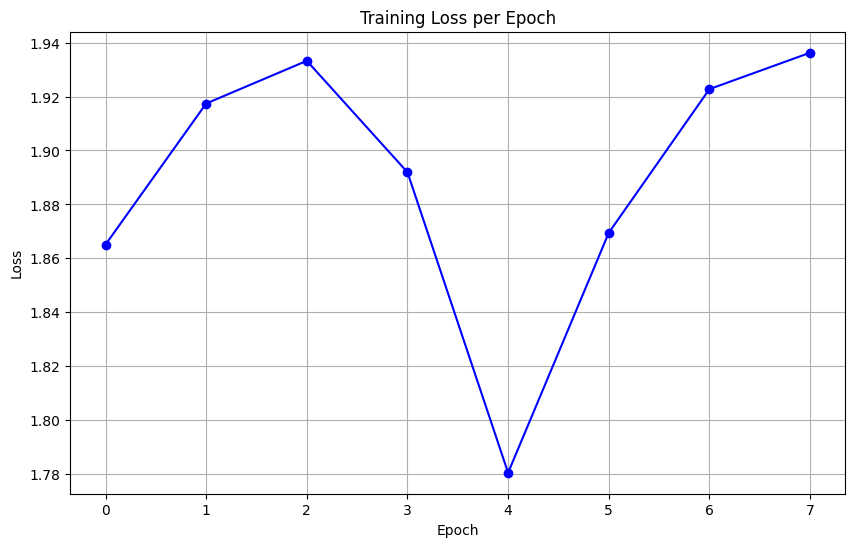

In [55]:
import random
import torch.nn.functional as F
from tqdm import tqdm
from transformers import AdamW, CONFIG_NAME, WEIGHTS_NAME
from peft import PromptTuningConfig, TaskType, PromptTuningInit, get_peft_model,PeftModel
import os
import matplotlib.pyplot as plt

def set_random_seed(seed):
  random.seed(seed)
  np.random.seed(seed)
  torch.manual_seed(seed)
  torch.cuda.manual_seed_all(seed)

def tts_to_labels(inputs, tts, label_tts):
  # Extract only the relevant token ids
  selector = torch.zeros_like(inputs, dtype=torch.bool)
  for tt in label_tts:
    selector |= tts == tt.value
  return torch.where(
      selector,
      inputs,
      torch.full_like(inputs, -1))

def plot_training_loss(train_history):
    """
    Plot the training loss over epochs.
    
    Args:
        train_history (list): List of training loss values for each epoch.
        train_num_epochs (int): Number of epochs.
    """

    train_num_epochs = len(train_history)
    plt.figure(figsize=(10, 6))
    epochs = np.arange(train_num_epochs)  # Array of epoch indices
    plt.plot(epochs, train_history, marker='o', linestyle='-', color='b')
    plt.title('Training Loss per Epoch')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.xticks(ticks=epochs)  # Set x-axis ticks to integer values
    plt.grid(True)
    plt.show()

def train_fn(train_dataloader,model,device,optimizer,num_virtual_tokens): 

  total_loss = 0
  train_context = False

  for batch in train_dataloader:

    inputs, tts = tuple(t.to(device) for t in batch)
    labels_context = tts_to_labels(inputs, tts, [TargetType.CONTEXT])
    labels_infill = tts_to_labels(inputs, tts, [TargetType.INFILL, TargetType.INFILL_SPECIAL])

    outputs = model(inputs)
    logits =  outputs.logits
    #logits_relevant = logits[:, :-1].contiguous().view(-1, logits.shape[-1])
    logits_relevant = logits[:, num_virtual_tokens:-1].contiguous().view(-1, logits.shape[-1])
    #logits_relevant = logits[:, num_virtual_tokens:].contiguous().view(-1, logits.shape[-1])

    #print("logits", logits_relevant.shape)
    #x = labels_context[:, :].contiguous().view(-1)
    #print(x.shape)
    #print("labels", labels_infill.shape)

    loss_context = F.cross_entropy(
        logits_relevant,
        labels_context[:, 1:].contiguous().view(-1),
        ignore_index=-1)
    
    loss_infill = F.cross_entropy(
        logits_relevant,
        labels_infill[:, 1:].contiguous().view(-1),
        ignore_index=-1)

    loss_context_item = loss_context.item()
    loss_infill_item = loss_infill.item()

    loss = loss_infill

    if train_context:
      loss += loss_context

    loss.backward()
    optimizer.step()
    optimizer.zero_grad()

    total_loss += loss.item()

  avg_train_loss = total_loss / len(train_dataloader)
  return avg_train_loss


def train_engine(train_loader,train_num_epochs,model, device,num_virtual_tokens):

  model.train()
  train_history = []

  train_learning_rate = 5e-5
  train_adam_epsilon = 1e-8

  optimizer = AdamW(
    model.parameters(),
    lr=train_learning_rate,
    eps=train_adam_epsilon)

  for i in range(train_num_epochs):
    train_loss = train_fn(train_loader, model, device,optimizer,num_virtual_tokens)
    train_history.append(train_loss)
    print(f"Epoch {i} , Train loss: {train_loss:.4f}")

  # Call the plotting function
  plot_training_loss(train_history)


  return model

def create_peft_model(num_virtual_tokens, model_path = "uw-hai/polyjuice"):
  
  foundational_model = AutoModelForCausalLM.from_pretrained(model_path)
  # Define prompt tuning configuration
  peft_config = PromptTuningConfig(
      task_type=TaskType.CAUSAL_LM, # This type indicates the model will generate text.
      prompt_tuning_init=PromptTuningInit.RANDOM,  # The added virtual tokens are initialized with random numbers
      num_virtual_tokens=num_virtual_tokens, # Number of virtual tokens to be added and trained.
      tokenizer_name_or_path=model_path # The pre-trained model.
  )

  peft_model = get_peft_model(foundational_model, peft_config)
  print(peft_model.print_trainable_parameters())

  return peft_model

def create_model_directories(base_dir, output_dir_name):
    """
    Creates the base and output directories for storing models if they do not exist.
    
    Parameters:
    base_dir (str): The base working directory.
    output_dir_name (str): The name of the output directory.
    
    Returns:
    str: The path to the output directory.
    """
    # Create the name of the output directory
    output_directory = os.path.join(base_dir, output_dir_name)
    
    # Create the base directory if it does not exist
    if not os.path.exists(base_dir):
        os.mkdir(base_dir)
    
    # Create the output directory if it does not exist
    if not os.path.exists(output_directory):
        os.mkdir(output_directory)
    
    return output_directory


# Create directory to save the trained model
working_dir="./"
output_dir_name="peft_outputs"
output_directory = create_model_directories(working_dir, output_dir_name)


# Parameters
seed = 40
EPOCHS = 8
num_virtual_tokens = 4

set_random_seed(seed)

# Create new model for soft tuning 
model_peft = create_peft_model(num_virtual_tokens)
model_peft.to(device)

trained_model = train_engine(train_dataloader,EPOCHS, model_peft, device,num_virtual_tokens)

# Save the trained model
trained_model.save_pretrained(output_directory)


### INFERENCE

In [37]:
class Modelinference:
    def __init__(self, model, tokenizer, output_dir_name):
        self.output_directory = output_dir_name
        self.foundational_model = model
        self.tokenizer = tokenizer
        

    #this function returns the outputs from the model received, and inputs.
    def get_outputs(self,model,inputs,do_sample=True,num_beams=None,num_return_sequences = 3):
        """
        Generates multiple sequences of text using the provided model and inputs.

        Args:
            model: The model used for generation.
            inputs (dict): Input tensors including 'input_ids' and 'attention_mask'.
            do_sample (bool, optional): Whether to use sampling during generation (default: True).
            num_beams (int, optional): Number of beams for beam search. Overrides `do_sample`.
            num_return_sequences (int, optional): Number of sequences to generate per input (default: 3).

        Returns:
            torch.Tensor: Tensor containing generated sequences.
        """

        outputs = model.generate(
            input_ids=inputs["input_ids"],
            attention_mask=inputs["attention_mask"],
            max_length=30,
            early_stopping=False, #if num_beams is None else True, #The model can stop before reach the max_length
            temperature= 1,
            num_beams=1 if num_beams is None else num_beams,
            do_sample=num_beams is None and do_sample,
            num_return_sequences=num_return_sequences,
        )
        return outputs
    
    def inference (self,input_prompt,num_return_sequences = 3, num_beams = 5 ):
        """
        Generate text sequences based on an input prompt using a pretrained model saved in the directory.

        Args:
            input_prompt (str): The input prompt text to generate sequences from.

        Returns:
            list: List of generated text sequences as decoded by the tokenizer, without special tokens.
        """

        loaded_model_prompt = PeftModel.from_pretrained(self.foundational_model,
                                         self.output_directory,
                                         device_map='auto',
                                         is_trainable=False)
        
        input_prompt_tok = self.tokenizer(input_prompt, return_tensors="pt")
        loaded_model_prompt_outputs = self.get_outputs(loaded_model_prompt, input_prompt_tok,num_beams = num_beams,num_return_sequences = num_return_sequences)
        result = self.tokenizer.batch_decode(loaded_model_prompt_outputs, skip_special_tokens=True)

        return result





In [56]:
print(output_directory)

./peft_outputs


In [52]:

input_prompt = "Her decision is rational love. <|perturb|> [negation] Her decision is [BLANK] love"

# Define your foundational model, tokenizer, and tokenized datasets
foundational_model = model
model_name = "uw-hai/polyjuice"

# Initialize the ModelTrainer class
inf_class =  Modelinference(foundational_model, tokenizer, output_directory)

sequence = inf_class.inference (input_prompt)
print(sequence)

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


['Her decision is rational love. <|perturb|> [negation] Her decision is [BLANK] love. [SEP] not', 'Her decision is rational love. <|perturb|> [negation] Her decision is [BLANK] love. " [SEP]', 'Her decision is rational love. <|perturb|> [negation] Her decision is [BLANK] love. [SEP] n']


In [205]:
print(inputs[0])
print(tts[0])

tensor([ 1169,  3807,   705,    82,  5365,  2829,  7110,   290,  8253, 18016,
          711,   880,   351,   262,  1527,   540,  3350,   764,  1279,    91,
        11766,  5945,    91,    29,   685, 12480,   341,    60,   262,  3807,
          705,    82,  5365,  2829,  7110,   290,   685,  9148, 15154,    60,
        18016,   711,   880,   351,   262,  1527,   540,  3350,   685,  5188,
           47,    60,  8820,   489,  3474,   685, 15037, 45532,    60,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0])
tensor([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2, 2, 2, 2, 2,
        2, 2, 2, 2, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2, 2, 2, 1, 1, 1, 1, 1, 1, 1, 1,
        3, 3, 3, 3, 4, 4, 4, 5, 5, 5, 5, 0, 0, 0, 0, 0, 0, 

In [81]:
#tokenized_datasets[0]
token_ids = tokenized_datasets[8]['input_ids']
decoded_text = text_format.tokenizer.decode(token_ids)
tokens_descomp = tokenizer.convert_ids_to_tokens(token_ids)
print(token_ids)
print(tokens_descomp)
print(decoded_text)

#[27, 91, 11766, 5945, 91, 29]

[49123, 329, 257, 2495, 15497, 11681, 1998, 764, 1279, 91, 11766, 5945, 91, 29, 685, 12480, 341, 60, 1838, 329, 257, 2495, 685, 9148, 15154, 60, 11681, 1998, 685, 5188, 47, 60, 22029, 685, 15037, 45532, 60, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
['makes', 'Ġfor', 'Ġa', 'Ġpretty', 'Ġpleasant', 'Ġviewing', 'Ġexperience', 'Ġ.', 'Ġ<', '|', 'pert', 'urb', '|', '>', 'Ġ[', 'neg', 'ation', ']', 'Ġmakes', 'Ġfor', 'Ġa', 'Ġpretty', 'Ġ[', 'BL', 'ANK', ']', 'Ġviewing', 'Ġexperience', 'Ġ[', 'SE', 'P', ']', 'Ġunpleasant', 'Ġ[', 'ANS', 'WER', ']', '!', '!', '!', '!', '!', '!', '!', '!', '!', '!', '!', '!', '!', '!', '!', '!', '!', '!', '!', '!', '!', '!', '!', '!', '!', '!', '!', '!', '!', '!', '!', '!', '!', '!', '!', '!', '!', '!', '!', '!', '!', '!', '!', '!', '!', '!', '!', '!', '!', '!', '!', '!', '!', '!', '!', '!', '!', '!', '!', '!', '!', '!', '!

In [4]:
from transformers import AutoTokenizer, AutoModelForCausalLM
model_path = "uw-hai/polyjuice"  
model = AutoModelForCausalLM.from_pretrained(model_path)
count_trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)

# Print the number of trainable parameters
print(f'Number of trainable parameters: {count_trainable_params}')

Number of trainable parameters: 124439808


## Datasets

In [11]:
import pickle
import pandas as pd

pickle_file_path = "../data/verbal/verbal_df.pkl"

# Load the pickle file
with open(pickle_file_path, 'rb') as file:
    data = pickle.load(file)

# Print the loaded pickle file data (optional, for verification)


In [14]:
pd.set_option('display.max_colwidth', None)
print(data.iloc[4])

Original_Sentence        Deng Yaping of China is the first female recorded at the inaugural Women ' s World Cup in 1996
Negated_Sentence     Deng Yaping of China is not the first female recorded at the inaugural Women ' s World Cup in 1996
Name: 4, dtype: object


In [ ]:
import pickle
import pandas as pd

pickle_file_path = "../data/verbal/verbal_df.pkl"

# Load the pickle file
with open(pickle_file_path, 'rb') as file:
    data2 = pickle.load(file)